In [136]:
import pandas as pd

In [137]:
## Entire data


bus_df = pd.read_csv('2020-10-28.csv',parse_dates = ["dateTime"])

In [138]:
# for a particular device id
frequent_device_id = '00000000078e6811'
frq_bus_df = hour_bucket = bus_df.loc[(bus_df.deviceId == frequent_device_id)]


In [139]:
total = len(frq_bus_df)

In [140]:
print("Hourly records sent by given bus id")
hourly_range = 1
for hour in range((int)(24/hourly_range)):
    start = hourly_range*hour
    end = start + hourly_range
    result = frq_bus_df.loc[(frq_bus_df.dateTime.apply(lambda x: x.hour) == start) ]
    
    for i in range(start+1,end):
        temp = frq_bus_df.loc[(frq_bus_df.dateTime.apply(lambda x: x.hour) == i) ]
        result = pd.concat([result,temp], ignore_index=True)
        
    
    print((start+5)%24,"hrs 30 mins",len(result), "(", len(result)/total*100 , "%)")

Hourly records sent by given bus id
5 hrs 30 mins 657 ( 4.240898528272656 %)
6 hrs 30 mins 577 ( 3.7245029692744644 %)
7 hrs 30 mins 138 ( 0.8907823392718823 %)
8 hrs 30 mins 152 ( 0.9811515620965658 %)
9 hrs 30 mins 930 ( 6.003098373353989 %)
10 hrs 30 mins 785 ( 5.067131422669765 %)
11 hrs 30 mins 840 ( 5.4221533694810224 %)
12 hrs 30 mins 681 ( 4.395817195972115 %)
13 hrs 30 mins 566 ( 3.653498579912213 %)
14 hrs 30 mins 681 ( 4.395817195972115 %)
15 hrs 30 mins 803 ( 5.183320423444358 %)
16 hrs 30 mins 812 ( 5.2414149238316545 %)
17 hrs 30 mins 726 ( 4.686289697908598 %)
18 hrs 30 mins 498 ( 3.214562354763749 %)
19 hrs 30 mins 550 ( 3.550219468112574 %)
20 hrs 30 mins 645 ( 4.163439194422928 %)
21 hrs 30 mins 861 ( 5.5577072037180475 %)
22 hrs 30 mins 801 ( 5.170410534469403 %)
23 hrs 30 mins 864 ( 5.57707203718048 %)
0 hrs 30 mins 804 ( 5.189775367931835 %)
1 hrs 30 mins 695 ( 4.486186418796798 %)
2 hrs 30 mins 0 ( 0.0 %)
3 hrs 30 mins 773 ( 4.989672088820036 %)
4 hrs 30 mins 653 

In [141]:
#------------------------------------------------
frq_bus_df = pd.read_csv('2020-10-25.csv',parse_dates = ["dateTime"])

In [142]:
total = len(frq_bus_df)
print(total)

16253


In [152]:
def distanceTravelled(df,time_slice,start_hour,hourly_range):
    '''
    df : dataframe under observation
    time_slice : time in minutes to compute euclidian distance
    start_hour : range(0,23) integer
    hourly_range : 1 hourly, 2 hourly, ...
    
    returns : distance travelled in meters
    '''
    total_distance = 0
    if len(df)<=1:
        return 0
    for i in range(hourly_range):
        current_hour = start_hour+i
        for slice_j in range((int)(60/time_slice)):
            current_min = time_slice*slice_j
            df_hour = df.loc[(df.dateTime.apply(lambda x: x.hour) == current_hour) ]
#             df_min = df_hour.loc[(df_hour.dateTime.apply(lambda x: x.minute) == 0) ]
#             print(current_hour, current_min, len(df_hour))
            total_distance += getSliceDistance(df_hour,current_min,time_slice)
    
    return total_distance
    
    
def getSlotwiseDistance(file_name,hourly_range,time_slice):
    '''
   file_name : name of the csv file
   hourly_range : 1 hourly, 2 hourly, ...
   time_slice : time in minutes to compute euclidian distance
   
   returns : distance in meters
   '''
    frq_bus_df = pd.read_csv(file_name,parse_dates = ["dateTime"])
    total = len(frq_bus_df)
#     hourly_range = 1
#     time_slice = 5
    distance_list = []
    for hour in range((int)(24/hourly_range)):
        start = hourly_range*hour
        end = start + hourly_range
        result = frq_bus_df.loc[(frq_bus_df.dateTime.apply(lambda x: x.hour) == start) ]

        for i in range(start+1,end):
            temp = frq_bus_df.loc[(frq_bus_df.dateTime.apply(lambda x: x.hour) == i) ]
            result = pd.concat([result,temp], ignore_index=True)

        total_distance = distanceTravelled(result, time_slice,start,hourly_range)
        distance_list.append(total_distance)

#         print((start+5)%24,"hrs 30 mins",len(result), "(", len(result)/total*100 , "%)")
#         print("distance travelled in meters ",total_distance)
    return distance_list

import geopy.distance
def getLatLongDistanceInMeters(start_lat,start_long, end_lat, end_long):
    coords_1 = (start_lat,start_long)
    coords_2 = (end_lat, end_long)
    return geopy.distance.geodesic(coords_1, coords_2).m
    
def getSliceDistance(df_hour,start_min,time_slice):
    
    result = df_hour.loc[(df_hour.dateTime.apply(lambda x: x.minute) == start_min) ]
    if len(result) <= 1 : 
        return 0
    start_lat = result.iloc[0]['lat']
    start_long = result.iloc[0]['long']
#     if start_min == 0 :
#         print("-----------------------------",start_lat)
        
#     print(len(result))
    if start_min + time_slice - 1 >= 60:
        end_min = 59
    else:
        end_min = (start_min + time_slice - 1)
    result = df_hour.loc[(df_hour.dateTime.apply(lambda x: x.minute) == end_min) ]
    if len(result) <= 1 : 
        return 0
    end_lat = result.iloc[-1]['lat']
    end_long = result.iloc[-1]['long']
    slice_distance = getLatLongDistanceInMeters(start_lat,start_long,end_lat,end_long)
    return slice_distance
def calculateAverageSpeed(file_name,start_hour, initial_start_min,
                          end_hour , end_min, time_slice):
    bus_df = pd.read_csv(file_name,parse_dates = ["dateTime"])
    total_distance = 0
    start_min = initial_start_min
    for hour in range(start_hour,end_hour+1):
        df_hour = bus_df.loc[(bus_df.dateTime.apply(lambda x: x.hour) == hour)]
        while start_min < 60 :
            if hour == end_hour and start_min >= end_min : 
                break
            total_distance += getSliceDistance(df_hour,start_min,time_slice )
            start_min += time_slice
        start_min = 0
    print('total distance' ,total_distance/1000.0 , 'Km' )
    
    time_hr = (end_hour - start_hour) + (end_min - initial_start_min)/60.0
    print('total time' , time_hr, 'hr(s)')
    return (total_distance/1000.0)/time_hr
    


In [156]:
distance_list_25 = np.array(getSlotwiseDistance('2020-10-25.csv',1,5))
# distance_list_27 = np.array(getSlotwiseDistance('2020-10-27.csv',1,1))
# distance_list_28 = np.array(getSlotwiseDistance('2020-10-28.csv',1,1))
print(distance_list_25)
print(distance_list_27)


[    0.           103.28973816    71.21708148    51.7553852
  8887.65798467 31471.54600686  3447.24517182 28834.53780196
   632.44635802   171.67102409  9215.95498105 19445.85805629
  2763.19235767 24354.55190743  3998.33673876 26424.96583363
   449.08040353 15447.92182825  8407.269777   14444.70033096
 14616.99318315     0.             0.             0.        ]
[    0.             0.             0.           152.84967465
 11715.29521972 30701.45467771  2361.97195156 27541.79377593
  1254.5030206   2729.68025093 16668.48054816 16921.24612023
  1850.39677044 22896.94142873  4249.54552615 21504.04533651
  6009.17488426 12039.30470765 13071.11319548 14468.58849669
 15291.77528989  1742.97061942    84.81442119   246.5086881 ]


In [154]:
#  dummy cell

hourly_range = 2   # number of hours
time_slice = 5  # in minutes
distance_list = []
for hour in range((int)(24/hourly_range)):
    start = hourly_range*hour
    end = start + hourly_range
    result = frq_bus_df.loc[(frq_bus_df.dateTime.apply(lambda x: x.hour) == start) ]
    
    for i in range(start+1,end):
        temp = frq_bus_df.loc[(frq_bus_df.dateTime.apply(lambda x: x.hour) == i) ]
        result = pd.concat([result,temp], ignore_index=True)
    
    total_distance = distanceTravelled(result, time_slice,start,hourly_range)
    distance_list.append(total_distance)
    
    print((start+5)%24,"hrs 30 mins",len(result), "(", len(result)/total*100 , "%)")
    print("distance travelled in meters ",total_distance)

5 hrs 30 mins 729 ( 4.485325786008737 %)
distance travelled in meters  103.28973816127257
7 hrs 30 mins 1868 ( 11.493262782255584 %)
distance travelled in meters  122.97246667813754
9 hrs 30 mins 1785 ( 10.982587829939087 %)
distance travelled in meters  40359.20399153077
11 hrs 30 mins 1509 ( 9.28443979573002 %)
distance travelled in meters  32281.782973780686
13 hrs 30 mins 1349 ( 8.300006152710269 %)
distance travelled in meters  804.1173821042224
15 hrs 30 mins 1750 ( 10.767242970528518 %)
distance travelled in meters  28661.813037338263
17 hrs 30 mins 1443 ( 8.878360917984372 %)
distance travelled in meters  27117.744265106194
19 hrs 30 mins 1329 ( 8.1769519473328 %)
distance travelled in meters  30423.302572387736
21 hrs 30 mins 1795 ( 11.044114932627823 %)
distance travelled in meters  15897.002231785093
23 hrs 30 mins 1759 ( 10.82261736294838 %)
distance travelled in meters  22851.970107955567
1 hrs 30 mins 890 ( 5.47591213929736 %)
distance travelled in meters  14616.993183151

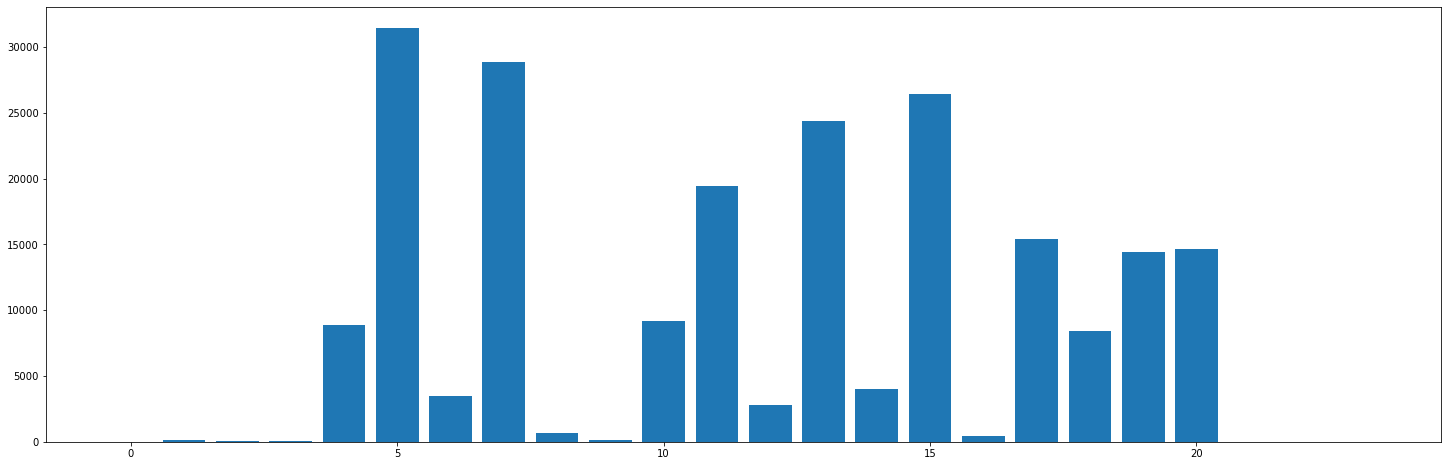

In [157]:
import matplotlib.pyplot as plt 
import numpy as np
fig = plt.subplots(figsize =(25, 8)) 
barWidth = 0.05
br1 = np.arange(len(distance_list_25)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
plt.bar(br1 , distance_list_25)
# plt.bar(br2 , distance_list_27)
# plt.bar(br3 , distance_list_28)

plt.show()

In [158]:
print(calculateAverageSpeed('2020-10-27.csv',10,57,11,37,5))

total distance 18.53713455738589 Km
total time 0.6666666666666667 hr(s)
27.805701836078832
